# Video Game Trends SQL Analysis

### Download the Datasets from Kaggle

In [1]:
import os
import shutil
from zipfile import ZipFile

# Remove existing data directory if it exists
if os.path.exists("../data"):
    shutil.rmtree("../data")
# Create a new data directory
os.makedirs("../data")
# Video Game Sales dataset
os.system("kaggle datasets download -d gregorut/videogamesales -p ../data/ --force")
# Video Game Reviews dataset
os.system("kaggle datasets download -d zaireali/metacritic-games-scrape -p ../data/ --force")

# Unzip the downloaded files
with ZipFile("../data/videogamesales.zip", "r") as zip_ref:
    zip_ref.extractall("../data/")
with ZipFile("../data/metacritic-games-scrape.zip", "r") as zip_ref:
    zip_ref.extractall("../data/")

# # Remove the zip files after extraction
os.remove("../data/videogamesales.zip")
os.remove("../data/metacritic-games-scrape.zip")

print("Datasets downloaded and extracted to '../data/' folder.")

Datasets downloaded and extracted to '../data/' folder.


### Build the Database

In [2]:
import pandas as pd
import sqlite3

# Open the connection and cursor to the SQLite database (to be closed at the end of the notebook)
conn = sqlite3.connect("../data/games.db")
cur = conn.cursor()
# Load and clean GAME SALES data
game_sales_df = pd.read_csv("../data/vgsales.csv")
game_sales_df.columns = [col.strip().replace(" ", "_").lower() for col in game_sales_df.columns]
game_sales_df.rename(columns={"name": "title", "platform": "platform_abbr"}, inplace=True)
game_sales_df.to_sql("game_sales_original", conn, index=False, if_exists="replace")

# Load and clean REVIEWS data
reviews_df = pd.read_csv(
    "../data/dataset_metacritic_scraper_2025-02-15.csv",
    usecols=range(11),
    dtype={"metascore": "Int64"},
    na_values=["tbd"],
)
reviews_df.columns = [col.strip().replace(" ", "_").lower() for col in reviews_df.columns]
reviews_df.rename(
    columns={"genres/0": "genre", "section": "platform", "metascore": "critic_score_100"},
    inplace=True,
)
reviews_df.dropna(subset=["userscore", "critic_score_100"], inplace=True)
reviews_df.to_sql("reviews_original", conn, index=False, if_exists="replace")

print(
    "Database created at ../data/games.db with tables 'game_sales_original' and 'reviews_original'."
)

Database created at ../data/games.db with tables 'game_sales_original' and 'reviews_original'.


In [3]:
# drop columns: No need to drop year
print(len(game_sales_df))
game_sales_df.isna().sum()

16598


rank               0
title              0
platform_abbr      0
year             271
genre              0
publisher         58
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
global_sales       0
dtype: int64

In [4]:
# columns to consider dropping nas from: critic_score_100, user_score
print(len(reviews_df))
reviews_df.isna().sum()

11895


title                0
genre                0
critic_score_100     0
publishername        1
publisherurl         1
releasedate          9
platform             0
summary             34
type                 0
url                  0
userscore            0
dtype: int64

### Load SQL Extension and Connect

In [5]:
%load_ext sql
%sql sqlite:///../data/games.db

### Preprocessing SQL Code

#### Run SQL Script to Create Filtered Tables containing Dates of Interest

In [6]:
# Using SQL file located in sql/preprocessing/
with open("../sql/preprocessing/01_create_filtered_tables.sql") as file:
    cur.executescript(file.read())
conn.commit()  # save changes

#### Run SQL Script to Create Lookup Table

In [7]:
# Using SQL file located in sql/preprocessing/
with open("../sql/preprocessing/02_create_platform_lookup.sql") as file:
    cur.executescript(file.read())
conn.commit()  # save changes

In [8]:
%%sql
SELECT MIN(year) AS earliest_year, MAX(year) AS latest_year
FROM game_sales;

 * sqlite:///../data/games.db
Done.


earliest_year,latest_year
1996.0,2015.0


In [9]:
%%sql
SELECT MIN(releasedate) AS earliest_date, MAX(releasedate) AS latest_date
FROM reviews;

 * sqlite:///../data/games.db
Done.


earliest_date,latest_date
1996-02-29,2015-12-22


#### Run SQL Script to Add Full Platform Names to the Game Sales Table

In [10]:
# Using SQL file located in sql/preprocessing/
with open("../sql/preprocessing/03_add_full_names.sql") as file:
    cur.executescript(file.read())
conn.commit()  # save changes

#### Run SQL Script to Add User Score out of 100 to the Reviews Table

In [11]:
# Using SQL file located in sql/preprocessing/
with open("../sql/preprocessing/04_add_user_score_100.sql") as file:
    cur.executescript(file.read())
conn.commit()  # save changes

### Closing the Database Connection and Cursor

In [12]:
cur.close()
conn.close()

### Run Queries

#### What Genres Have the Largest and Smallest Disparity between User and Critic Score?
* Check what genres there are, with at least 10 games
    * Many genres, looks good. Limited to min 25.
* How to present results?
    * In SQL, list top 3 genres for the following:
        * avg_user_score, avg_critic_score, score_disparity (+ve), score_disparity (-ve), smallest score_disparity

#### Making a Table of the Data Grouped by Genres

In [13]:
%%sql
CREATE TEMP TABLE genres AS
SELECT genre,
       COUNT(*) AS num_games,
       ROUND(AVG(critic_score_100), 1) AS genre_critic_score,
       ROUND(AVG(user_score_100), 1) AS genre_user_score,
       ROUND(AVG(user_score_100) - AVG(critic_score_100), 1) AS score_disparity
FROM reviews
GROUP BY genre
HAVING COUNT(*) >= 25;

 * sqlite:///../data/games.db
Done.


[]

In [14]:
%%sql
SELECT * FROM genres ORDER BY score_disparity DESC LIMIT 5;

 * sqlite:///../data/games.db
Done.


genre,num_games,genre_critic_score,genre_user_score,score_disparity
3D Beat-'Em-Up,148,60.8,69.0,8.1
Soccer,25,70.4,77.8,7.4
RPG,58,67.1,73.0,5.9
Virtual Career,25,63.3,68.4,5.1
Action Adventure,393,66.3,70.4,4.0


#### Average Genre Values

In [15]:
%%sql
SELECT ROUND(AVG(genre_user_score), 1) AS avg_genre_user_score,
       ROUND(AVG(genre_critic_score), 1) AS avg_genre_critic_score,
       ROUND(AVG(score_disparity), 1) AS avg_score_disparity
FROM genres;

 * sqlite:///../data/games.db
Done.


avg_genre_user_score,avg_genre_critic_score,avg_score_disparity
70.0,71.1,-1.1


#### Highest Scores (According to Users and Critics)

In [16]:
%%sql
SELECT * FROM (
    SELECT ROW_NUMBER() OVER (ORDER BY genre_user_score DESC) AS rank,
        'user' AS score_type,
        genre,
        genre_user_score AS score
    FROM genres
    ORDER BY genre_user_score DESC
    LIMIT 3
)
UNION ALL
SELECT * FROM (
    SELECT ROW_NUMBER() OVER (ORDER BY genre_critic_score DESC) AS rank,
        'critic' AS score_type,
        genre,
        genre_critic_score AS score
    FROM genres
    ORDER BY genre_critic_score DESC
    LIMIT 3
);

 * sqlite:///../data/games.db
Done.


rank,score_type,genre,score
1,user,Metroidvania,79.1
2,user,Trainer RPG,78.8
3,user,Soccer,77.8
1,critic,Football Sim,82.9
2,critic,Metroidvania,81.2
3,critic,Soccer Sim,80.9


#### Lowest Scores (According to Users and Critics)

In [17]:
%%sql
SELECT * FROM (
    SELECT ROW_NUMBER() OVER (ORDER BY genre_user_score DESC) AS rank,
        'user' AS score_type,
        genre,
        genre_user_score AS score
    FROM genres
    ORDER BY genre_user_score
    LIMIT 3
)
UNION ALL
SELECT * FROM (
    SELECT ROW_NUMBER() OVER (ORDER BY genre_critic_score DESC) AS rank,
        'critic' AS score_type,
        genre,
        genre_critic_score AS score
    FROM genres
    ORDER BY genre_critic_score
    LIMIT 3
);

 * sqlite:///../data/games.db
Done.


rank,score_type,genre,score
68,user,Football Sim,60.9
67,user,Party,63.3
66,user,Board,64.2
67,critic,3D Beat-'Em-Up,60.8
68,critic,Party,60.8
66,critic,Action,61.5


#### Biggest and Smallest Discrepancies between Users and Critics

In [18]:
%%sql
SELECT * FROM (
    SELECT ROW_NUMBER() OVER (ORDER BY score_disparity DESC) AS rank,
        'largest positive' AS discrepancy_type,
        genre,
        score_disparity
    FROM genres
    ORDER BY score_disparity DESC
    LIMIT 3
)
UNION ALL
SELECT * FROM (
    SELECT ROW_NUMBER() OVER (ORDER BY ABS(score_disparity)) AS rank,
        'smallest' AS discrepancy_type,
        genre,
        ABS(score_disparity) as score_disparity
    FROM genres
    ORDER BY score_disparity
    LIMIT 3
)
UNION ALL
SELECT * FROM (
    SELECT ROW_NUMBER() OVER (ORDER BY score_disparity) AS rank,
        'largest negative' AS discrepancy_type,
        genre,
        score_disparity
    FROM genres
    ORDER BY score_disparity
    LIMIT 3
);

 * sqlite:///../data/games.db
Done.


rank,discrepancy_type,genre,score_disparity
1,largest positive,3D Beat-'Em-Up,8.1
2,largest positive,Soccer,7.4
3,largest positive,RPG,5.9
1,smallest,Card Battle,0.0
2,smallest,Defense,0.1
3,smallest,Wrestling,0.1
1,largest negative,Football Sim,-22.0
2,largest negative,Soccer Sim,-14.9
3,largest negative,Baseball Sim,-14.7


### What is the Correlation between User Score, Critic Score, and Game Sales?
* Can combine in SQL and get some basic numbers.
* Then may need to use Python to actually plot and find the correlations. May be good to do a 3D plot as they are three things.

Note on Bias
* The review data comes from the website Metacritic, which has much more visibility in Europe and North America compared with other regions. For this reason, the na_sales and eu_sales will be combined together to make western_sales for this analysis.

Potential Questions:
* Are either of user scores and critic scores a good predictor of sales?
* Which is more strongly associated with sales: user score or critic score?
* 

What hypotheses can be made from the results?

In [19]:
%%sql
SELECT 'joined' AS type, COUNT(*) AS num_games
FROM reviews
INNER JOIN game_sales
USING (title, platform)
UNION ALL
SELECT 'reviews only' AS type, COUNT(*) AS num_games
FROM reviews
UNION ALL
SELECT 'sales only' AS type, COUNT(*) AS num_games
FROM game_sales;

 * sqlite:///../data/games.db
Done.


type,num_games
joined,3337
reviews only,7336
sales only,15274


#### Confirm No Nulls are Present in Dataset of Interest

In [20]:
%%sql
SELECT
    SUM(CASE WHEN title IS NULL THEN 1 ELSE 0 END) AS null_title,
    SUM(CASE WHEN platform IS NULL THEN 1 ELSE 0 END) AS null_platform,
    SUM(CASE WHEN releasedate IS NULL THEN 1 ELSE 0 END) AS null_releasedate,
    SUM(CASE WHEN critic_score_100 IS NULL THEN 1 ELSE 0 END) AS null_critic_score_100,
    SUM(CASE WHEN user_score_100 IS NULL THEN 1 ELSE 0 END) AS null_user_score_100,
    SUM(CASE WHEN na_sales IS NULL THEN 1 ELSE 0 END) AS null_na_sales,
    SUM(CASE WHEN eu_sales IS NULL THEN 1 ELSE 0 END) AS null_eu_sales
FROM reviews
INNER JOIN game_sales
USING (title, platform);

 * sqlite:///../data/games.db
Done.


null_title,null_platform,null_releasedate,null_critic_score_100,null_user_score_100,null_na_sales,null_eu_sales
0,0,0,0,0,0,0


In [32]:
%%sql
-- For reviewing the below query (delete when done)
SELECT title, platform, releasedate, critic_score_100, user_score_100, na_sales + eu_sales AS western_sales, jp_sales
FROM reviews
INNER JOIN game_sales
USING (title, platform)
WHERE western_sales <> 0
ORDER BY western_sales
LIMIT 10;

 * sqlite:///../data/games.db
Done.


title,platform,releasedate,critic_score_100,user_score_100,western_sales,jp_sales
Inazuma Eleven Strikers,Wii,2011-07-16,59,80,0.01,0.25
Cubivore: Survival of the Fittest,GameCube,2002-11-05,71,75,0.01,0.15
Pokemon Rumble World,3DS,2015-04-08,58,62,0.01,0.08
Saint Seiya: Brave Soldiers,PlayStation 3,2013-11-26,55,73,0.01,0.06
Virtua Striker 2002,GameCube,2002-05-20,58,68,0.01,0.03
Child of Light,PlayStation 4,2014-04-29,82,80,0.01,0.04
Yu-Gi-Oh! World Championship 2007,DS,2007-03-20,76,70,0.01,0.04
Front Mission,DS,2007-10-23,72,69,0.01,0.03
Electroplankton,DS,2006-01-09,71,72,0.01,0.02
Gotcha Force,GameCube,2003-12-03,56,85,0.01,0.01


## Output the SQL Query as a Pandas Dataframe

Note, games with zero western sales are removed from the dataset, to exclude those games which were not sold in the west.

In [33]:
query = """
SELECT title, platform, releasedate, critic_score_100, user_score_100,
       na_sales + eu_sales AS western_sales
FROM reviews
INNER JOIN game_sales
USING (title, platform)
WHERE western_sales <> 0;
"""
# IPython magic to run SQL query (VS Code shows red but it works)
result = %sql $query
df = result.DataFrame()
df.head()

 * sqlite:///../data/games.db
Done.


,title,platform,releasedate,critic_score_100,user_score_100,western_sales
0,Wii Sports,Wii,2006-11-19,76,80,70.51
1,Mario Kart Wii,Wii,2008-04-27,82,86,28.73
2,Wii Sports Resort,Wii,2009-07-26,80,84,26.76
3,New Super Mario Bros.,DS,2006-05-15,89,85,20.61
4,Wii Play,Wii,2007-02-12,58,66,23.23


#### Python Analysis on the Score and Sales Table

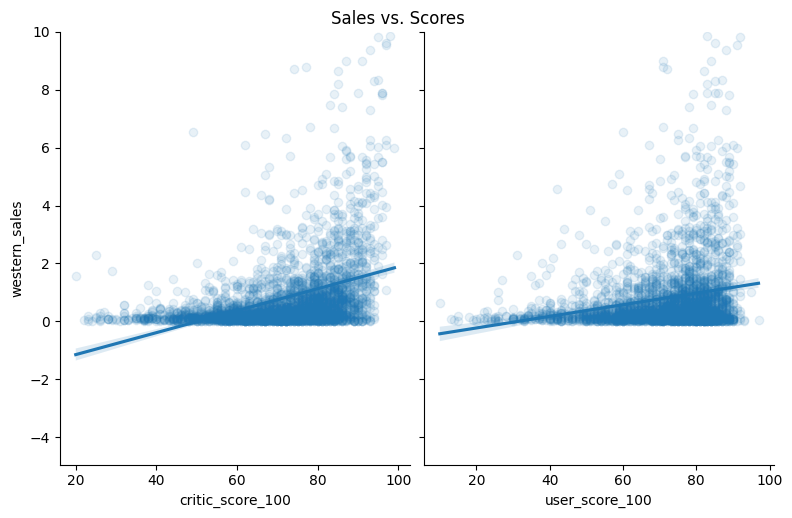

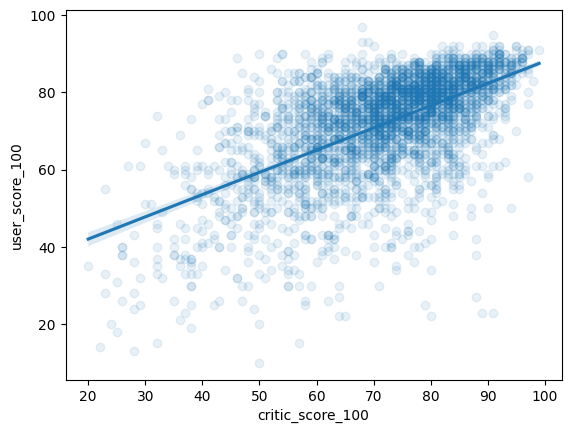

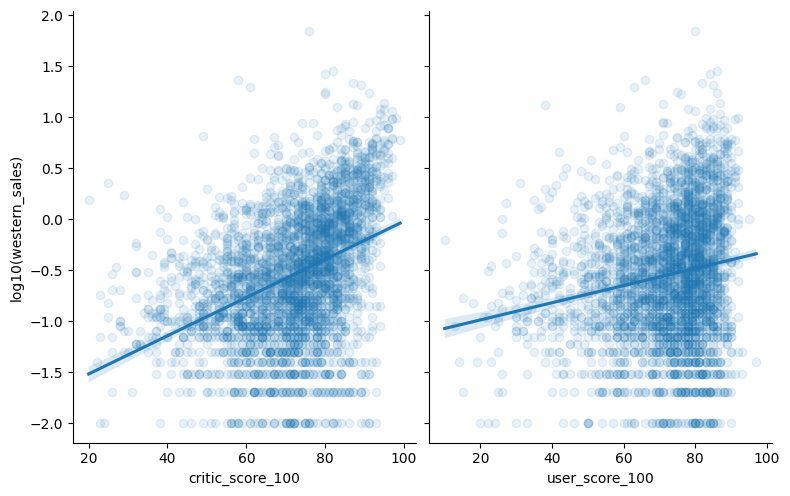

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# NOTE: releasedate was set as the colour ('c' parameter) but it was not useful

g1 = sns.pairplot(
    df,
    # vars=["critic_score_100", "user_score_100", "western_sales"],
    x_vars=["critic_score_100", "user_score_100"],
    y_vars="western_sales",
    height=5,
    aspect=0.8,
    kind="reg",
    plot_kws={"scatter_kws": {"alpha": 0.1}},
)
plt.suptitle("Sales vs. Scores", y=1.02)

plt.ylim(top=10)

plt.show()

g2 = sns.regplot(df, x="critic_score_100", y="user_score_100", scatter_kws={"alpha": 0.1})

plt.show()

# Make a copy with log-transformed y
df_log = df.copy()
df_log["log_western_sales"] = np.log10(df_log["western_sales"])

# Plot linear regression on log(y)
g = sns.pairplot(
    df_log,
    x_vars=["critic_score_100", "user_score_100"],
    y_vars="log_western_sales",
    height=5,
    aspect=0.8,
    kind="reg",
    plot_kws={"scatter_kws": {"alpha": 0.1}},
)

# Adjust y-axis labels back to original scale if desired
for ax in g.axes.flat:
    ax.set_ylabel("log10(western_sales)")

plt.show()

## Tables for reference

In [24]:
%%sql
SELECT * FROM game_sales LIMIT 2;

 * sqlite:///../data/games.db
Done.


rank,title,platform_abbr,year,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales,platform
1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,Wii
3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,Wii


In [25]:
%%sql
SELECT * FROM reviews LIMIT 0;

 * sqlite:///../data/games.db
Done.


title,genre,critic_score_100,publishername,publisherurl,releasedate,platform,summary,type,url,userscore,user_score_100


In [26]:
%%sql
SELECT * FROM reviews LIMIT 1;

 * sqlite:///../data/games.db
Done.


title,genre,critic_score_100,publishername,publisherurl,releasedate,platform,summary,type,url,userscore,user_score_100
Tekken 3,3D Fighting,96,Namco,https://www.metacritic.com/company/namco/,1998-04-29,PlayStation,"An ancient evil force has reawakened, attacking in secret and feeding on the souls of mighty warriors. To lure it out of hiding will take the greatest fighting contest the world has ever seen...Tekken 3. Some are fighting for revenge, some for honor, Ultimately, all are fighting for their lives and the fate of all mankind.",game,https://www.metacritic.com/game/tekken-3,8.9,89
